<a href="https://colab.research.google.com/github/ridhimagarg/PyTorchBook/blob/main/Chapter2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import datetime
import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
def make_val_step(model, loss_fn):

  def perform_val_step(x, y):

    model.eval()

    yhat = model(x)

    loss = loss_fn(yhat, y)

    return loss.item()

  return perform_val_step

In [29]:
class StepByStep(object):
  def __init__(self, model, loss_fn, optimizer):
    self.model = model
    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    self.model.to(self.device)

    self.train_loader = None
    self.val_loader = None
    self.writer = None

    self.losses = []
    self.val_losses = []
    self.total_epochs = 0

    self.train_step = self._make_train_step()
    self.val_step = self._make_val_step()

    self.mini_batch = self._mini_batch()

  def to(self, device):
    self.device = device
    self.model.to(self.device)

  def set_loaders(self, train_loader, val_loader=None):

    self.train_loader = train_loader
    self.val_loader = val_loader

  def set_tensorboard(self, name, folder='runs'):

    suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
    self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

  def _make_train_step(self):

    def perform_train_step(x, y):

      self.model.train()
      yhat = self.model(x)

      loss = self.loss_fn(yhat, y)

      loss.backward()

      self.optimizer.step()
      self.optimizer.zero_grad()

      return loss.item()

    return perform_train_step

  def _make_val_step(self):
    # Builds function that performs a step in the validation loop
    def perform_val_step(x, y):
      # Sets model to EVAL mode
      self.model.eval()
      # Step 1 - Computes model's predicted output - forward pass
      yhat = self.model(x)
      # Step 2 - Computes the loss
      loss = self.loss_fn(yhat, y)
      # There is no need to compute Steps 3 and 4,
      # since we don't update parameters during evaluation
      return loss.item()
    return perform_val_step

  def _mini_batch(self, validation=False):

    if validation:
      data_loader = self.val_loader
      step = self.val_step

    else:
      data_loader = self.train_loader
      step = self.train_step

    if data_loader is None:
      return None

    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
      x_batch = x_batch.to(self.device)
      y_batch = y_batch.to(self.device)

      mini_batch_loss = step(x_batch, y_batch)
      mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)

    return loss



def set_seed(self, seed=42):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    torch.manual_seed(seed)
    np.random.seed(seed)


setattr(StepByStep, 'set_seed', set_seed)


def train(self, n_epochs, seed=42):

  self.set_seed(42)

  for epoch in range(n_epochs):

    self.total_epochs +=1

    loss = self._mini_batch(validation=False)
    self.losses.append(loss)

    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
      # Performs evaluation using mini-batches
      val_loss = self._mini_batch(validation=True)
      self.val_losses.append(val_loss)

    if self.writer:

      scalars = {'training': loss}
      if val_loss is not None:
        scalars.update({'validation': val_loss})

      self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)

  if self.writer:
    self.writer.flush()

setattr(StepByStep, 'train', train)

def save_checkpoint(self, filename):
  # Builds dictionary with all elements for resuming training
  checkpoint = {
  'epoch': self.total_epochs,
  'model_state_dict': self.model.state_dict(),
  'optimizer_state_dict': self.optimizer.state_dict(),
  'loss': self.losses,
  'val_loss': self.val_losses
  }
  torch.save(checkpoint, filename)

setattr(StepByStep, 'save_checkpoint', save_checkpoint)

def load_checkpoint(self, filename):

  checkpoint = torch.load(filename)

  self.model.load_state_dict (checkpoint['model_state_dict'])
  self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  self.total_epochs = checkpoint['epoch']
  self.losses = checkpoint["loss"]
  self.val_losses = checkpoint["val_loss"]

  self.model.train() ## remember to set it to train.

setattr(StepByStep, 'load_checkpoint', load_checkpoint)


def predict(self, x):

  self.model.eval()

  x_tensor = torch.as_tensor(x).float()

  y_hat_tensor = self.model(x_tensor.to(self.device))

  self.model.train()

  return y_hat_tensor.detach().cpu().numpy()

setattr(StepByStep, 'predict', predict) 

def plot_losses(self):

  print(self.losses)
  print(self.val_losses)

  fig = plt.figure(figsize=(10,4))
  plt.plot(self.losses, label="Training Loss", c="b")

  if self.val_loader:
    plt.plot(self.val_losses, label="Validation Loss", c="r")
    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()

    return fig

setattr(StepByStep, 'plot_losses', plot_losses)

def add_graph(self):
  if self.train_loader and self.writer:
    x_dummy = y_dummy = next(iter(self.train_loader))

    self.writer.add_graph(self.model, x_dummy.to(self.device))

setattr(StepByStep, 'add_graph', add_graph)

    

## Classy Pipeline

In [7]:
## data generation

 # %load data_preparation/v2.py
torch.manual_seed(42)

true_b = 1
true_w = 2
N = 100
# Data Generation
np.random.seed(42)
x = np.random.rand(N, 1)
epsilon = (.1 * np.random.randn(N, 1))
y = true_b + true_w * x + epsilon

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

ratio = 0.8
n_total = len(dataset)
n_train = int(n_total*ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True )
val_loader = DataLoader(dataset=val_data, batch_size=16)

In [10]:
## model configuration
# %%writefile model_configuration/v4.py

lr = 0.1

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1,1))

optimizer = optim.SGD(model.parameters(), lr=lr)

loss_fn = nn.MSELoss(reduction="mean")

In [11]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[0.7645]])), ('0.bias', tensor([0.8300]))])


In [36]:
## model training using the class

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')

# the sbs object is the same object as the model variable created in the model configuration. It is not a copy!
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [37]:
sbs.train(n_epochs=200)
print(model.state_dict()) # remember, model == sbs.model
print(sbs.total_epochs)


OrderedDict([('0.weight', tensor([[1.9584]])), ('0.bias', tensor([1.0099]))])
200


[0.008103259187191725, 0.008090755715966225, 0.008110600430518389, 0.008108102809637785, 0.008103875070810318, 0.008090910222381353, 0.008086178638041019, 0.00823542643338442, 0.008195825945585966, 0.00807939637452364, 0.008051646128296851, 0.008254422433674335, 0.008071400970220566, 0.008068094495683908, 0.008110717497766018, 0.008085128292441368, 0.008105919696390629, 0.00812521711923182, 0.00821544360369444, 0.008101074304431678, 0.008164090290665626, 0.008082118071615695, 0.008067409787327052, 0.008081210218369961, 0.008044863305985927, 0.008063959190621972, 0.008150563016533852, 0.008157016383484006, 0.008213325589895248, 0.008176823705434799, 0.008191375434398651, 0.008069305587559939, 0.00808620359748602, 0.008057249337434768, 0.008201230503618716, 0.008178186137229204, 0.008149013854563236, 0.008178454544395208, 0.00823700213804841, 0.008180422056466342, 0.008135184179991484, 0.008082398120313883, 0.008134271763265134, 0.008112376276403665, 0.00808522030711174, 0.00817572576925

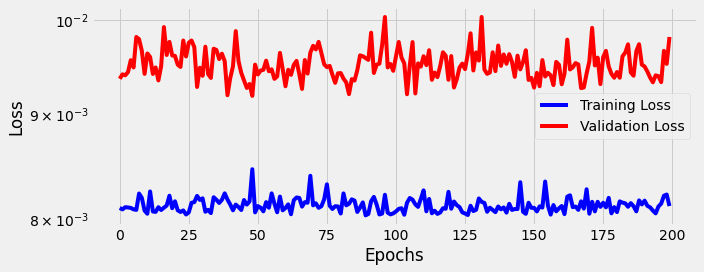

In [38]:
fig = sbs.plot_losses()

In [39]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)

In [40]:
predictions = sbs.predict(new_data)
print(predictions)

[[1.9891284]
 [1.5974442]
 [2.3808126]]


In [41]:
sbs.save_checkpoint('model_checkpoint.pth')